In [26]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
#%matplotlib 

## Transformada de Fourier en 2D
Podemos interpretar los cambios de intensidad de la imagen como funciones sobre un plano

![SNOWFALL](fourier.png)

In [27]:
# Leemos ambas imagenes
img_low_freq = cv.imread('fft_hf.jpg', cv.IMREAD_GRAYSCALE)
img_hig_freq = cv.imread('fft_lf.jpg', cv.IMREAD_GRAYSCALE)
# Aplico la transformada
img_fft_low = np.fft.fft2(img_low_freq)
img_fft_hig = np.fft.fft2(img_hig_freq)
# llevo la baja frec al origen para acomodar la visualizacion
img_fft_low = np.fft.fftshift(img_fft_low)
img_fft_hig = np.fft.fftshift(img_fft_hig)
# obtengo el modulo
img_fft_low = 20*np.log(np.abs(img_fft_low))
img_fft_hig = 20*np.log(np.abs(img_fft_hig))
# Tomamos un "perfil" de una fila por cada imagen
low_freq_sg = img_low_freq[50,10:60]
hig_freq_sg = img_hig_freq[50,10:60]

Graficamos los resultados

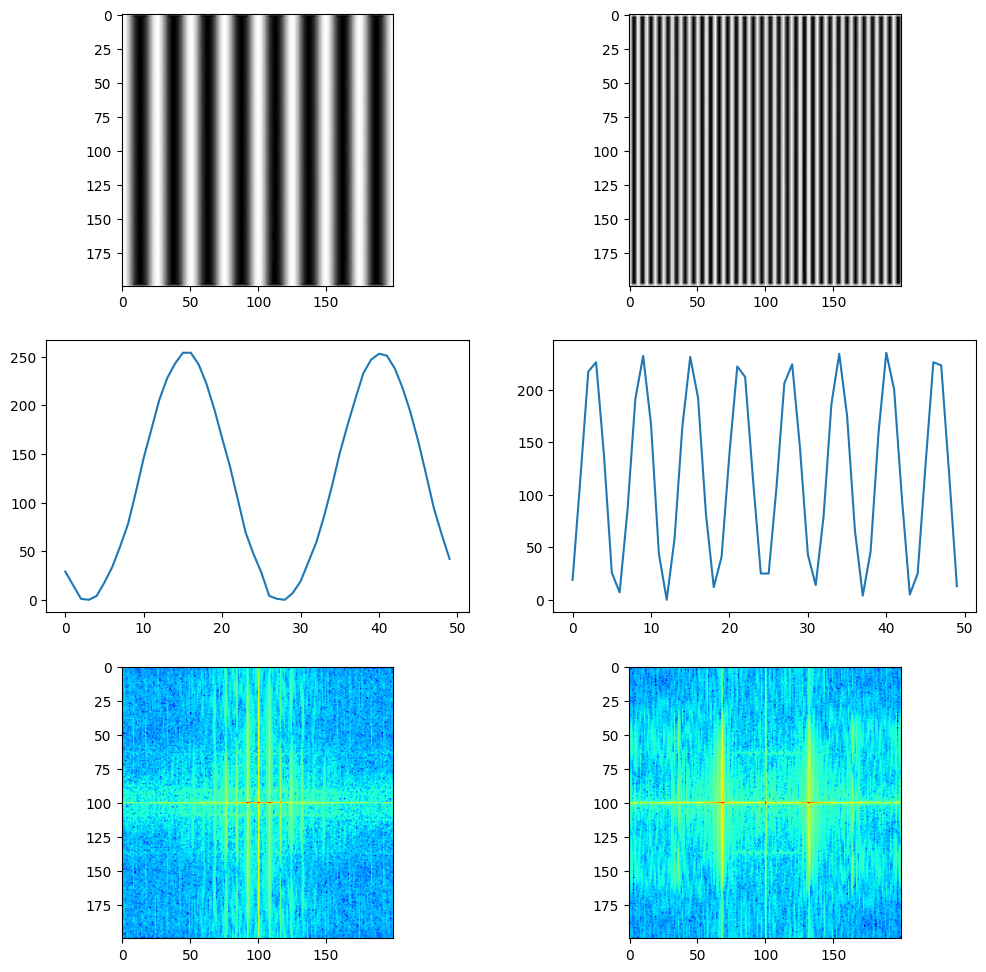

In [28]:
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(img_low_freq, cmap='gray')
plt.subplot(3,2,2)
plt.imshow(img_hig_freq, cmap='gray')

plt.subplot(3,2,3)
plt.plot(low_freq_sg)
plt.subplot(3,2,4)
plt.plot(hig_freq_sg)

plt.subplot(3,2,5)
plt.imshow(img_fft_low, cmap='jet')
plt.subplot(3,2,6)
plt.imshow(img_fft_hig, cmap='jet')

## Filtros en el dominio espectral

In [29]:
# funciones auxiliares
def fft2_mod(image):

  shifted_image_fft = np.fft.fftshift(np.fft.fft2(image))

  return 20*np.log(np.abs(shifted_image_fft))


def _filter_round_shape(height, width, radius):
  canvas = np.zeros((height, width))
  return cv.circle(canvas,
                     center=(int(canvas.shape[1]/2), int(canvas.shape[0]/2)),
                     radius=radius,
                     color=(255),
                     thickness=-1).astype(np.uint8)


def create_lp_filter(height, width, radius=20):

  lp_filter = _filter_round_shape(height, width, radius)
  return lp_filter


def create_hp_filter(height, width, radius=60):

  lp_filter = _filter_round_shape(height, width, radius)
  return cv.bitwise_not(lp_filter)

In [30]:
# leo la imagen en escala de grises
img = cv.imread('fft_alfa_pred.png', cv.IMREAD_GRAYSCALE)
# obtengo el modulo de la transformada de fourier
mod = fft2_mod(img)

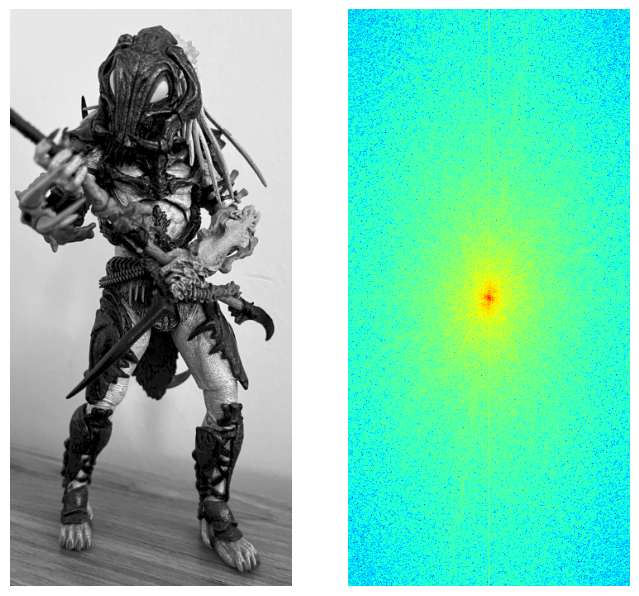

In [31]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.axis('off')
plt.imshow(img, cmap='gray')
plt.subplot(1,2,2)
plt.axis('off')
plt.imshow(mod, cmap='jet')

### Definimos los filtros en el dominio espectral

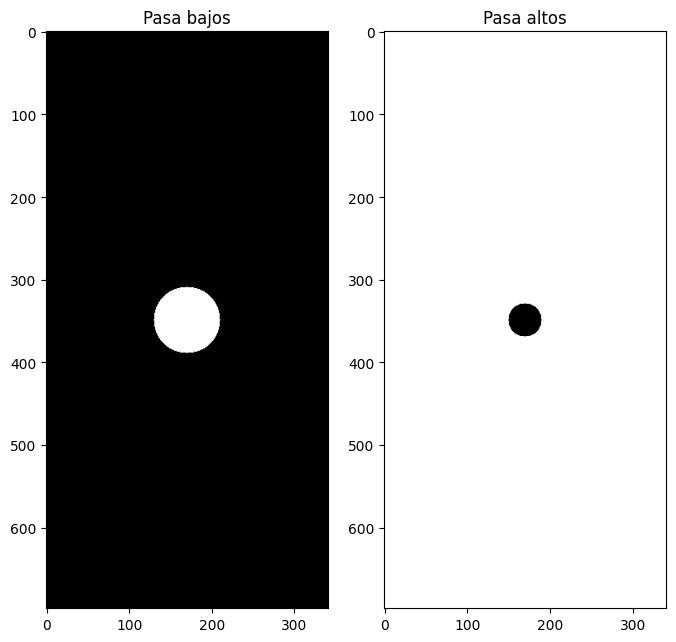

In [32]:
h, w = img.shape
lp_filter = create_lp_filter(h, w, radius=40)
hp_filter = create_hp_filter(h, w, radius=20)

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(lp_filter, cmap='gray')
plt.title('Pasa bajos')
plt.subplot(1,2,2)
plt.title('Pasa altos')
plt.imshow(hp_filter, cmap='gray')

### Aplicamos los filtros a la imagen

In [33]:
# vuelvo a calcular la FFT. Para aplicar el filtro 
# necesito la transformada en modulo y fase en el dominio
# de los numeros complejos
shifted_fft = np.fft.fftshift(np.fft.fft2(img))
lp_filtered = shifted_fft * lp_filter
hp_filtered = shifted_fft * hp_filter

# Aplicamos la antitransformada y obtenemos las imagenes filtradas
f_ishift = np.fft.ifftshift(lp_filtered)
img_lp = np.real(np.fft.ifft2(f_ishift))
f_ishift = np.fft.ifftshift(hp_filtered)
img_hp = np.real(np.fft.ifft2(f_ishift))

### Graficamos los resultados

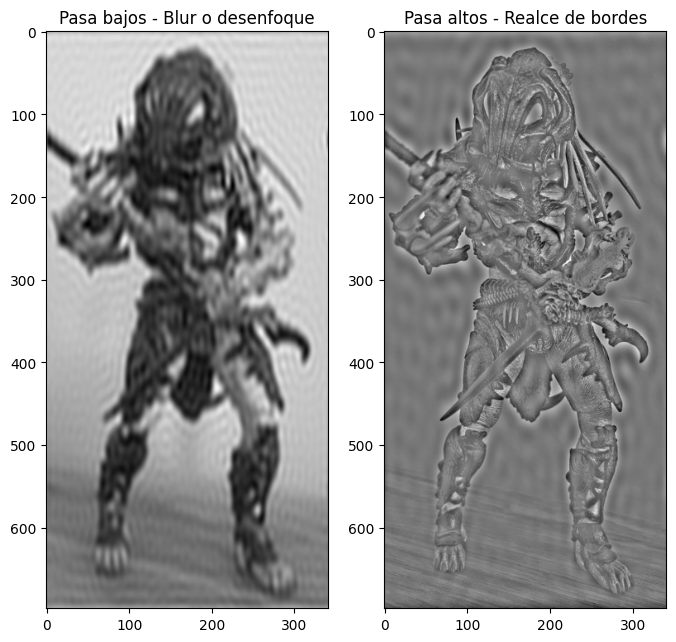

In [34]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.imshow(img_lp, cmap='gray')
plt.title('Pasa bajos - Blur o desenfoque')
plt.subplot(1,2,2)
plt.title('Pasa altos - Realce de bordes')
plt.imshow(img_hp, cmap='gray')

In [35]:
# Get the indexes of the center point of an image.
def getCenter(img):
    center = np.floor((np.array(img.shape)/2.0)).astype('uint')
    return np.array([center[0],center[1]],dtype='uint')

# Place image at the center of a canvas array
def placeOnCenter(canvas,img, offsetXY = [0,0]):
    diff = np.clip(np.floor((img.shape[0] - canvas.shape[0]) / 2.0),a_min=0,a_max=None).astype('uint')
    sx = slice(diff,np.clip(img.shape[0]-diff,0,canvas.shape[0]+diff))
    diff = np.clip(np.floor((img.shape[1] - canvas.shape[1]) / 2.0),a_min=0,a_max=None).astype('uint')
    sy = slice(diff,np.clip(img.shape[1]-diff,0,canvas.shape[1]+diff))
    img = img[sx,sy,...]
    top_corners = (getCenter(canvas) - getCenter(img) + np.array(offsetXY)).clip(0,np.iinfo('uint').max).astype('uint')
    sx = slice(top_corners[0], (top_corners[0] + img.shape[0]).clip(0,canvas.shape[0]))
    sy = slice(top_corners[1], (top_corners[1] + img.shape[1]).clip(0,canvas.shape[1]))
    # TODP: slice img when out of bounds by offset.
    canvas[sx,sy,...] = img
    return canvas

def create_gauss_filter(h, w, k_size = 5, sigma = 0.5):
    canvas = np.zeros((h,w))
    k_1d = cv.getGaussianKernel(k_size,sigma)
    k_2d = k_1d * k_1d.T
    filter_spatial = placeOnCenter(canvas,k_2d)
    filter_spectral = np.fft.fft2(filter_spatial)
    return filter_spatial,filter_spectral

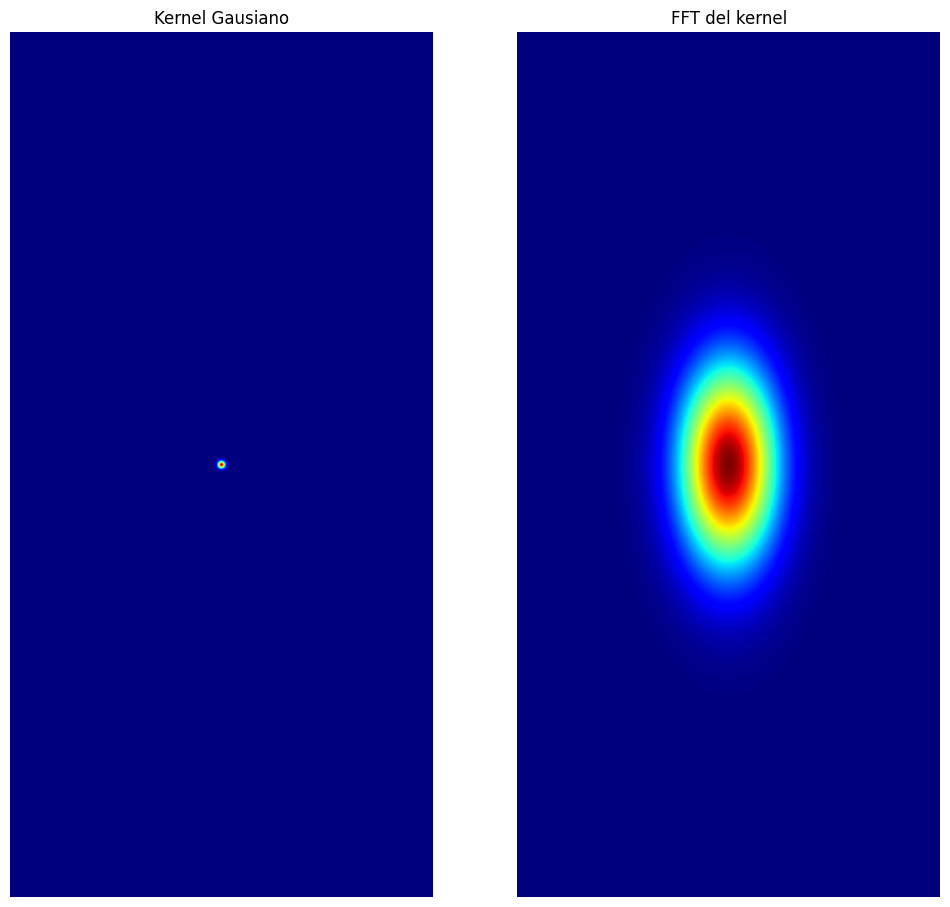

In [36]:
kernel, kernel_tf = create_gauss_filter(h, w, k_size=15, sigma=2)

plt.figure(figsize=(12,12))
plt.subplot(1,2,1)
plt.axis('off')
plt.title("Kernel Gausiano")
plt.imshow(kernel, cmap='jet')
plt.subplot(1,2,2)
plt.axis('off')
plt.title("FFT del kernel")
tf_shifted = np.fft.fftshift(kernel_tf)
plt.imshow(np.abs(tf_shifted), cmap='jet')

Text(0.5, 1.0, 'Desenfoque gausiano')

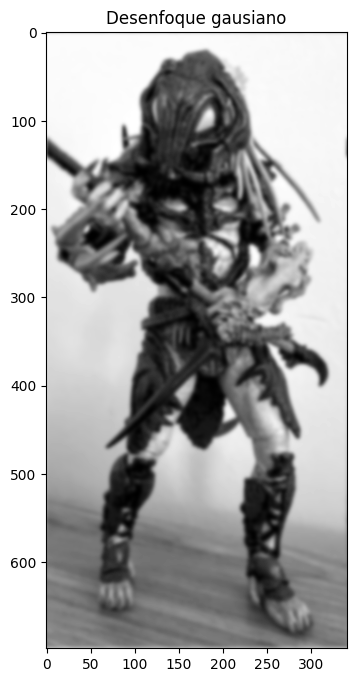

In [37]:
img_fft = np.fft.fft2(img)
filtered = img_fft * kernel_tf

img_gauss = np.fft.ifftshift(np.real(np.fft.ifft2(filtered)))

plt.figure(figsize=(8,8))
plt.imshow(img_gauss, cmap='gray')
plt.title('Desenfoque gausiano')